In [87]:
## pip install xgboost

In [133]:
## submodules that provides functions and classes for splitting data, performing cross-validation, and evaluating models like r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
import seaborn as sns
import numpy as np


In [242]:
combined_stats = pd.read_csv('Data/2025FantasyFootballProjections2.csv')

In [244]:
combined_stats.head()

,ID,Player,Tm,FantPos,2023Age,2023G,2023HealthGrades,2023HealthGrades2,2023Cmp,2023Att,...,2025TD,CBS2025PPR,ESPN2025PPR,FullTraining,XGBoostRFR,XGBoostCV,FullTrainingDiff.,XGBoostRFRDiff.,XGBoostCVDiff,2025Diff
0,1,Josh Allen,BUF,QB,27,17,0,Healthy,385,579,...,41.0,431.3,365.5,411.14,431.24,NaN,-45.6,NaN,NaN,NaN
1,2,Christian McCaffrey,SF,RB,27,16,0,Healthy,0,0,...,11.0,292.6,322.0,238.30,125.82,NaN,83.7,NaN,NaN,NaN
2,3,CeeDee Lamb,DAL,WR/TE,24,17,0,Healthy,0,0,...,8.0,304.6,314.7,286.03,293.79,NaN,28.7,NaN,NaN,NaN
3,4,Jalen Hurts,PHI,QB,25,17,0,Healthy,352,538,...,40.0,422.8,363.2,403.55,420.30,NaN,-40.4,NaN,NaN,NaN
4,5,Tyreek Hill,MIA,WR/TE,29,16,0,Healthy,0,0,...,8.0,261.0,262.7,261.55,262.92,NaN,1.1,NaN,NaN,NaN


In [246]:
combined_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283 entries, 0 to 282
Data columns (total 86 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           283 non-null    int64  
 1   Player                       283 non-null    object 
 2   Tm                           283 non-null    object 
 3   FantPos                      283 non-null    object 
 4   2023Age                      283 non-null    int64  
 5   2023G                        283 non-null    int64  
 6   2023HealthGrades             283 non-null    int64  
 7   2023HealthGrades2            283 non-null    object 
 8   2023Cmp                      283 non-null    int64  
 9   2023Att                      283 non-null    int64  
 10  2023PassYds                  283 non-null    int64  
 11  2023PassTD                   283 non-null    int64  
 12  2023Int                      283 non-null    int64  
 13  2023RushAtt         

In [248]:
combined_stats.groupby('FantPos')['ESPN2025PPR'].describe()

,count,mean,std,min,25%,50%,75%,max
FantPos,,,,,,,,
QB,39.0,234.528205,102.113232,0.0,166.45,271.90,298.600,366.3
RB,88.0,139.047727,98.424613,10.2,40.00,110.45,219.575,336.3
WR/TE,156.0,141.519872,83.775206,0.0,75.75,140.05,206.550,353.0


In [250]:
# Convert columns to numeric, handling errors
numeric_columns = [
    '2024PassYds', '2024RushYds', '2024RecYds'
]

In [252]:
for col in numeric_columns:
    combined_stats[col] = pd.to_numeric(combined_stats[col], errors='coerce')

In [254]:

def train_and_predict(position, features):
    # Filter the dataset to include only the players at the specified position
    position_data = combined_stats[combined_stats['FantPos'] == position].copy()

    # Handle case where no data is available for the specified position
    if position_data.empty:
        print(f"No data found for position: {position}")
        return pd.DataFrame()

    # Select feature columns and target column, filling missing values with 0
    X = position_data[features].fillna(0)
    y = position_data['ESPN2025PPR'].fillna(0)

    # Reset indices for alignment
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    position_data = position_data.reset_index(drop=True)

    # Split into training and testing sets (80% train, 20% test), preserving indices
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X, y, position_data.index, test_size=0.2, random_state=42
    )

    # Add a column to indicate which rows are train/test
    position_data.loc[idx_train, 'Data Split'] = 'Train'
    position_data.loc[idx_test, 'Data Split'] = 'Test'

    # Initialize and train XGBoost regressor model
    xgb = XGBRegressor(
        n_estimators=150,         # Number of boosting rounds
        max_depth=2,              # Shallow trees to reduce overfitting
        learning_rate=0.1,        # Controls step size shrinkage
        subsample=0.8,            # Fraction of training samples used per tree
        colsample_bynode=0.8,     # Fraction of features used per tree node
        reg_alpha=0.1,            # L1 regularization
        reg_lambda=1,             # L2 regularization
        random_state=42           # Reproducibility
    )
    xgb.fit(X_train, y_train)

    # Generate predictions for both train and test sets
    y_pred_train = xgb.predict(X_train)
    y_pred_test = xgb.predict(X_test)

    # Evaluate model performance using Mean Absolute Error (MAE)
    print(f"\n{position} - Training MAE: {mean_absolute_error(y_train, y_pred_train)}")
    print(f"{position} - Testing MAE: {mean_absolute_error(y_test, y_pred_test)}")

    # Extract and display feature importance scores
    feature_importances = xgb.feature_importances_
    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print(f"\n{position} - Feature Importances:")
    print(importance_df)

    # Predict fantasy points for the full dataset (train + test)
    position_data['Predicted Fantasy Points'] = xgb.predict(X)

    # Return key columns for analysis or export
    return position_data[['Player', 'Data Split', 'FantPos', 'Rookie', 'Predicted Fantasy Points', 'ESPN2025PPR']]

# Feature sets per position based on relevant historical stats and health metrics
# Define feature sets for each position, including past PPR points and new features
rb_features = ['2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023FL', '2023TD', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age', 'AdjustedRisk']
wrte_features = ['2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023FL', '2023TD', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age', 'AdjustedRisk']
# te_features = ['2023Rec', '2023RecTD', '2023FL', '2023TD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age', 'AdjustedRisk', 'ProjectedRole']
qb_features = ['2023PassYds', '2023PassTD', '2023RushYds', '2023RushTD', '2023FL', '2023TD', '2024RushYds', '2024RushTD', '2024FL', '2024PassYds', '2024PassTD', 'HealthGrade', '2025Age', 'AdjustedRisk']

# Generate predictions for each position
rb_predictions = train_and_predict('RB', rb_features)
wrte_predictions = train_and_predict('WR/TE', wrte_features)
# te_predictions = train_and_predict('TE', te_features)
qb_predictions = train_and_predict('QB', qb_features)

# Combine all position results and round to 2 decimal places
all_predictions = pd.concat([rb_predictions, wrte_predictions, qb_predictions]).round(2)

# The override_dict is used to find specific players (like Tank Dell) in the DataFrame and update their projected points and notes accordingly
# Looping through dictionary to find specific players.
override_dict = {
    'Tank Dell': {'points': 0, 'note': 'Out for season'},
    'Mike Williams': {'points': 0, 'note': 'Retired'},
    'Will Levis': {'points':0, 'note': 'Out for season'}
}

for player, override in override_dict.items():
    all_predictions.loc[all_predictions['Player'] == player, 'Predicted Fantasy Points'] = override['points']
    all_predictions.loc[all_predictions['Player'] == player, 'Note'] = override['note']

# Export results to CSV
output_path = "Data/FantasyFootballPrediction_XGB2.csv"
all_predictions[['Player', 'Data Split', 'FantPos', 'Rookie', 'Predicted Fantasy Points', 'ESPN2025PPR']].to_csv(output_path, index=False)


RB - Training MAE: 7.899518677847729
RB - Testing MAE: 48.633177291022406

RB - Feature Importances:
         Feature  Importance
9     2024RushTD    0.266050
7    2024RushAtt    0.211137
12     2024RecTD    0.115152
10       2024Rec    0.055032
8    2024RushYds    0.048067
11    2024RecYds    0.045519
3        2023Rec    0.038469
1    2023RushYds    0.036368
15       2025Age    0.028109
5         2023FL    0.026856
16  AdjustedRisk    0.026270
0    2023RushAtt    0.023971
4      2023RecTD    0.020600
2     2023RushTD    0.020144
13        2024FL    0.019007
6         2023TD    0.012298
14   HealthGrade    0.006953

WR/TE - Training MAE: 17.709903000247095
WR/TE - Testing MAE: 39.20661400556564

WR/TE - Feature Importances:
         Feature  Importance
10       2024Rec    0.315485
3        2023Rec    0.149427
12     2024RecTD    0.117876
11    2024RecYds    0.089101
15       2025Age    0.064325
8    2024RushYds    0.042379
1    2023RushYds    0.032112
16  AdjustedRisk    0.031510
4   

In [256]:
# Evaluate R² and MAE by position (testing data only)
# Start with an empty Python list

position_metrics = []

for pos in all_predictions['FantPos'].unique():
    subset = all_predictions[all_predictions['FantPos'] == pos]
    r2 = r2_score(subset['ESPN2025PPR'], subset['Predicted Fantasy Points'])
    mae = mean_absolute_error(subset['ESPN2025PPR'], subset['Predicted Fantasy Points'])
    position_metrics.append({'Position': pos, 'R²': round(r2, 3), 'MAE': round(mae, 2)})

# Convert to DataFrame for easy viewing
# So after the loop, position_metrics becomes a list of dictionaries, which is then converted to a pandas dataframe
position_metrics_df = pd.DataFrame(position_metrics)

print("\nPerformance Metrics by Position:")
print(position_metrics_df)


Performance Metrics by Position:
  Position     R²    MAE
0       RB  0.888  16.23
1    WR/TE  0.879  21.64
2       QB  0.816  18.03


In [258]:
# Evaluate R² and MAE by position (testing data only)
# Start with an empty Python list
position_metrics = []

# Filter for test data only
test_only = all_predictions[all_predictions['Data Split'] == 'Test']

for pos in test_only['FantPos'].unique():
    subset = test_only[test_only['FantPos'] == pos]
    r2 = r2_score(subset['ESPN2025PPR'], subset['Predicted Fantasy Points'])
    mae = mean_absolute_error(subset['ESPN2025PPR'], subset['Predicted Fantasy Points'])
    position_metrics.append({'Position': pos, 'R²': round(r2, 3), 'MAE': round(mae, 2)})

# So after the loop, position_metrics becomes a list of dictionaries, which is then converted to a pandas dataframe
# Convert to DataFrame for easy viewing
position_metrics_df = pd.DataFrame(position_metrics)

print("\nPerformance Metrics by Position: (Testing)")
print(position_metrics_df)


Performance Metrics by Position: (Testing)
  Position     R²    MAE
0       RB  0.524  48.63
1    WR/TE  0.531  39.21
2       QB -0.579  72.23


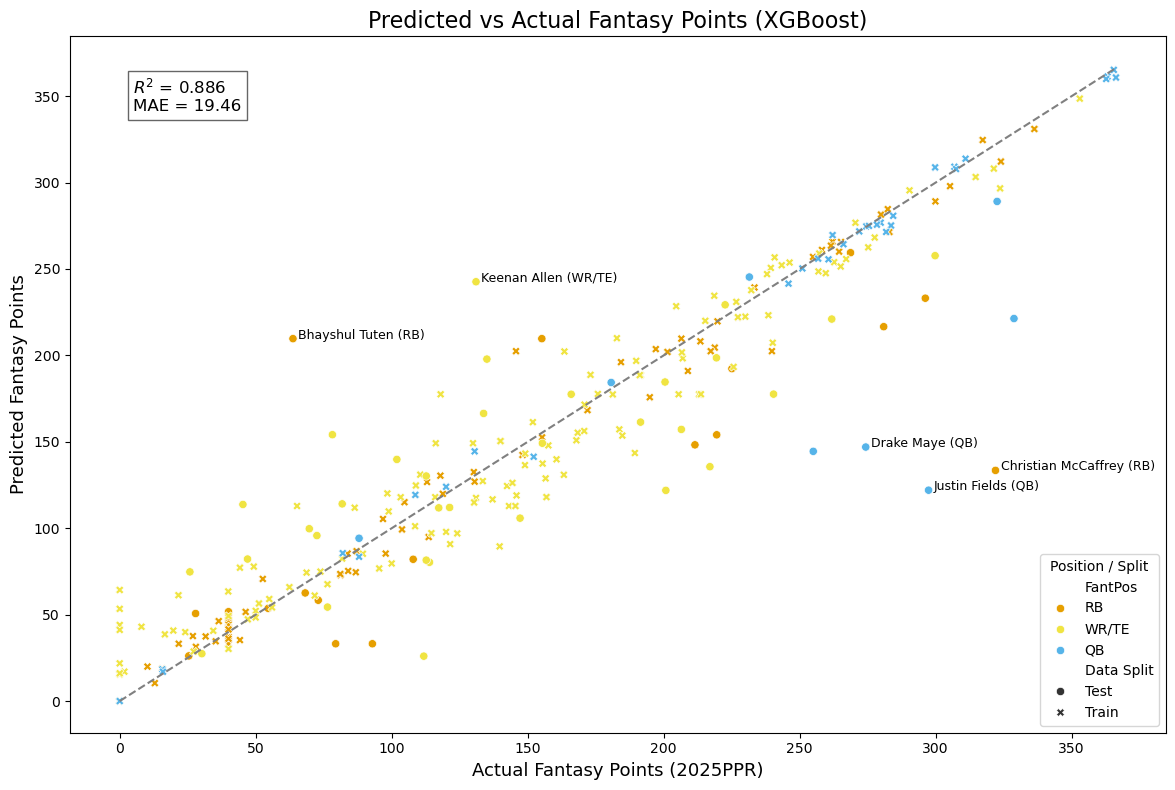

In [260]:
# Compute R² and MAE for the whole dataset
r2 = r2_score(all_predictions['ESPN2025PPR'], all_predictions['Predicted Fantasy Points'])
mae = mean_absolute_error(all_predictions['ESPN2025PPR'], all_predictions['Predicted Fantasy Points'])

# Calculate residuals
all_predictions['Residual'] = np.abs(all_predictions['ESPN2025PPR'] - all_predictions['Predicted Fantasy Points'])

# Get top 5 outliers
top_outliers = all_predictions.nlargest(5, 'Residual')

# Colorblind-friendly palette (Color Universal Design)
color_palette = {
    'RB': '#E69F00',  # orange
    'WR/TE': '#F0E442',  # blue
    #'TE': '#009E73',  # green
    'QB': '#56B4E9'   # yellow
}

# Plotting
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=all_predictions,
    x='ESPN2025PPR',
    y='Predicted Fantasy Points',
    hue='FantPos',
    style='Data Split',
    palette=color_palette
)

# Diagonal line for reference (perfect prediction)
min_val = min(all_predictions['ESPN2025PPR'].min(), all_predictions['Predicted Fantasy Points'].min())
max_val = max(all_predictions['ESPN2025PPR'].max(), all_predictions['Predicted Fantasy Points'].max())
plt.plot([min_val, max_val], [min_val, max_val], ls="--", color='gray')

# Annotate top residual outliers
for _, row in top_outliers.iterrows():
    plt.text(row['ESPN2025PPR'] + 2, row['Predicted Fantasy Points'],
             f"{row['Player']} ({row['FantPos']})", fontsize=9, color='black')

# Labels and title
plt.title('Predicted vs Actual Fantasy Points (XGBoost)', fontsize=16)
plt.xlabel('Actual Fantasy Points (2025PPR)', fontsize=13)
plt.ylabel('Predicted Fantasy Points', fontsize=13)

# Display R² and MAE on the plot
plt.text(min_val + 5, max_val - 25,
         f"$R^2$ = {r2:.3f}\nMAE = {mae:.2f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.6))

# Legend and layout
plt.legend(title='Position / Split', loc='lower right')
plt.tight_layout()
plt.show()

In [262]:
all_predictions['ValuationDiff'] = all_predictions['Predicted Fantasy Points'] - all_predictions['ESPN2025PPR']

In [264]:
# Top 10 overvalued players (Predicted > Actual)
overvalued = all_predictions.sort_values(by='ValuationDiff', ascending=False).head(10)

print("Most Overvalued Fantasy Players:")
print(overvalued[['Player', 'FantPos', 'Data Split', 'ESPN2025PPR', 'Predicted Fantasy Points', 'ValuationDiff']])

Most Overvalued Fantasy Players:
               Player FantPos Data Split  ESPN2025PPR  \
76     Bhayshul Tuten      RB       Test         63.7   
15       Keenan Allen   WR/TE       Test        131.0   
76    Adonai Mitchell   WR/TE       Test         78.2   
90       Elijah Moore   WR/TE       Test         45.3   
145    Kayshon Boutte   WR/TE      Train          0.0   
96        Jonnu Smith   WR/TE       Test        135.0   
137         Jack Bech   WR/TE      Train        118.0   
75   Quinshon Judkins      RB      Train        145.7   
79       Cam Skattebo      RB       Test        155.2   
79         Tyler Boyd   WR/TE      Train          0.0   

     Predicted Fantasy Points  ValuationDiff  
76                 209.699997     145.999997  
15                 242.619995     111.619995  
76                 154.130005      75.930005  
90                 113.760002      68.460002  
145                 64.279999      64.279999  
96                 197.869995      62.869995  
137       

In [266]:
# Top 10 undervalued players (Actual > Predicted)
undervalued = all_predictions.sort_values(by='ValuationDiff').head(10)

print("Most Undervalued Fantasy Players:")
print(undervalued[['Player', 'FantPos', 'Data Split', 'ESPN2025PPR', 'Predicted Fantasy Points', 'ValuationDiff']])

Most Undervalued Fantasy Players:
                  Player FantPos Data Split  ESPN2025PPR  \
0    Christian McCaffrey      RB       Test        322.0   
27         Justin Fields      QB       Test        297.4   
26            Drake Maye      QB       Test        274.3   
36              Cam Ward      QB       Test        255.0   
6             Joe Burrow      QB       Test        328.8   
93         Josh Reynolds   WR/TE       Test        111.8   
132          Rome Odunze   WR/TE       Test        217.0   
18      Deebo Samuel Sr.   WR/TE       Test        200.8   
18          Tony Pollard      RB       Test        219.5   
10         Derrick Henry      RB       Test        280.9   

     Predicted Fantasy Points  ValuationDiff  
0                  133.470001    -188.529999  
27                 122.019997    -175.380003  
26                 146.979996    -127.320004  
36                 144.490005    -110.509995  
6                  221.330002    -107.469998  
93                  25.

## XGBoost and Cross Validation Applied
* This function trains a position-specific XGBoost model using 5-fold cross-validation to find the best number of boosting rounds, then fits a final model on all the data for that position and returns predictions vs. actual ESPN 2025 PPR points.

In [269]:
import xgboost as xgb

def train_and_predict_cv(position, features, n_folds=5):
    # Filter data for the current position
    position_data = combined_stats[combined_stats['FantPos'] == position].copy()
    
    if position_data.empty:
        print(f"No data found for position: {position}")
        return pd.DataFrame()

    # Select features and target variable (PPR fantasy points for 2025)
    X = position_data[features].fillna(0)
    y = position_data['ESPN2025PPR'].fillna(0)

    # Reset index for clean processing
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    position_data = position_data.reset_index(drop=True)

    # Convert data to DMatrix for XGBoost (efficient format)
    dmatrix = xgb.DMatrix(X, label=y)

    # XGBoost parameters with regularization to reduce overfitting
    params = {
        "objective": "reg:squarederror",   # Regression problem
        "max_depth": 3,                    # Shallow trees to avoid overfitting
        "learning_rate": 0.1,              # Standard learning rate
        "lambda": 1,                       # L2 regularization
        "alpha": 0.1,                      # L1 regularization
        "seed": 42,                        # Reproducibility
        "eval_metric": "mae"               # Evaluation based on Mean Absolute Error
    }

    # 5-fold cross-validation with early stopping (to avoid overfitting)
    print(f"\nPerforming cross-validation for {position}...")
    cv_results = xgb.cv(
        params=params,
        dtrain=dmatrix,
        nfold=5,                          # 5-fold CV
        num_boost_round=150,              # Max trees
        early_stopping_rounds=10,         # Stop if no improvement for 10 rounds
        metrics="mae",
        seed=42,
        verbose_eval=False
    )

    # Determine best iteration (lowest validation MAE)
    best_n_rounds = cv_results['test-mae-mean'].idxmin()
    print(f"{position} - Best MAE: {cv_results['test-mae-mean'].min():.4f} at {best_n_rounds} rounds")

    # Train final model using all data and the best number of rounds
    model = xgb.train(params, dmatrix, num_boost_round=best_n_rounds)

    # --- Feature importance extraction from the trained XGBoost model ---

# Get raw feature importance scores using 'gain' (total gain across all splits using the features)
    importance_dict = model.get_score(importance_type='gain')

# Check if the model has any boosting rounds and importance values
    if importance_dict:
        # Convert the importance dictionary to a DataFrame
        importance_df = pd.DataFrame({
        'Feature': list(importance_dict.keys()),
        'Importance': list(importance_dict.values()),  # Raw gain values (can be very large)
        'Position': position                           # Add property type label for identification
        }).sort_values(by='Importance', ascending=False).reset_index(drop=True)

        # Normalize importance values to sum to 100% for easier comparison between features
        total = importance_df['Importance'].sum()
        importance_df['NormalizedImportance'] = importance_df['Importance'] / total * 100

        # Print the importance table for this property type
        print(f"\n{position} - Feature Importances:")
        print(importance_df)

    else:
        # If no boosting rounds were run (early stopping at 0), feature importance will be empty
        print(f"\n{position} - No feature importance (likely due to 0 boosting rounds).")

    # Generate predictions for the entire dataset
    position_data['Predicted Fantasy Points'] = model.predict(dmatrix)

    return position_data[['Player', 'FantPos', 'Rookie', 'Predicted Fantasy Points', 'ESPN2025PPR']]


# Feature sets per position based on relevant historical stats and health metrics
# Define feature sets for each position, including past PPR points and new features
rb_features = ['2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023FL', '2023TD', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age', 'AdjustedRisk']
wrte_features = ['2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023FL', '2023TD', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age', 'AdjustedRisk']
# te_features = ['2023Rec', '2023RecTD', '2023FL', '2023TD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age', 'AdjustedRisk', 'ProjectedRole']
qb_features = ['2023PassYds', '2023PassTD', '2023RushYds', '2023RushTD', '2023FL', '2023TD', '2024RushYds', '2024RushTD', '2024FL', '2024PassYds', '2024PassTD', 'HealthGrade', '2025Age', 'AdjustedRisk']

# Generate predictions for each position
rb_predictions = train_and_predict_cv('RB', rb_features, n_folds=5)
wrte_predictions = train_and_predict_cv('WR/TE', wrte_features, n_folds=5)
qb_predictions = train_and_predict_cv('QB', qb_features, n_folds=3)  # Use 3-fold CV for QBs

# Combine all position results and round to 2 decimal places
all_predictions = pd.concat([rb_predictions, wrte_predictions, qb_predictions]).round(2)

override_dict = {
    'Tank Dell': {'points': 0, 'note': 'Out for season'},
    'Mike Williams': {'points': 0, 'note': 'Retired'},
    'Will Levis': {'points':0, 'note': 'Out for season'}
}

for player, override in override_dict.items():
    all_predictions.loc[all_predictions['Player'] == player, 'Predicted Fantasy Points'] = override['points']
    all_predictions.loc[all_predictions['Player'] == player, 'Note'] = override['note']

# Save results to CSV
output_path = "Data/FantasyFootballPrediction_XGB_CV3.csv"
all_predictions[['Player', 'FantPos', 'Rookie', 'Predicted Fantasy Points', 'ESPN2025PPR']].to_csv(output_path, index=False)


Performing cross-validation for RB...
RB - Best MAE: 43.3147 at 35 rounds

RB - Feature Importances:
         Feature    Importance Position  NormalizedImportance
0    2024RushAtt  79443.390625       RB             44.782658
1        2023Rec  22027.617188       RB             12.417084
2    HealthGrade  16727.888672       RB              9.429599
3     2024RushTD  14043.957031       RB              7.916653
4        2024Rec  11163.673828       RB              6.293022
5     2024RecYds   5969.109375       RB              3.364818
6      2024RecTD   5624.925781       RB              3.170800
7    2023RushYds   4218.483887       RB              2.377982
8         2023TD   3284.567871       RB              1.851528
9    2024RushYds   2754.028076       RB              1.552460
10       2025Age   2650.952393       RB              1.494356
11     2023RecTD   2295.197754       RB              1.293815
12   2023RushAtt   1861.029541       RB              1.049072
13        2024FL   1727.796509

In [271]:
# Evaluate R² and MAE by position
position_metrics = []

for pos in all_predictions['FantPos'].unique():
    subset = all_predictions[all_predictions['FantPos'] == pos]
    r2 = r2_score(subset['ESPN2025PPR'], subset['Predicted Fantasy Points'])
    mae = mean_absolute_error(subset['ESPN2025PPR'], subset['Predicted Fantasy Points'])
    position_metrics.append({'Position': pos, 'R²': round(r2, 3), 'MAE': round(mae, 2)})

# Convert to DataFrame for easy viewing
position_metrics_df = pd.DataFrame(position_metrics)

print("\nPerformance Metrics by Position:")
print(position_metrics_df)


Performance Metrics by Position:
  Position     R²    MAE
0       RB  0.942  17.18
1    WR/TE  0.904  19.83
2       QB  0.955  14.43


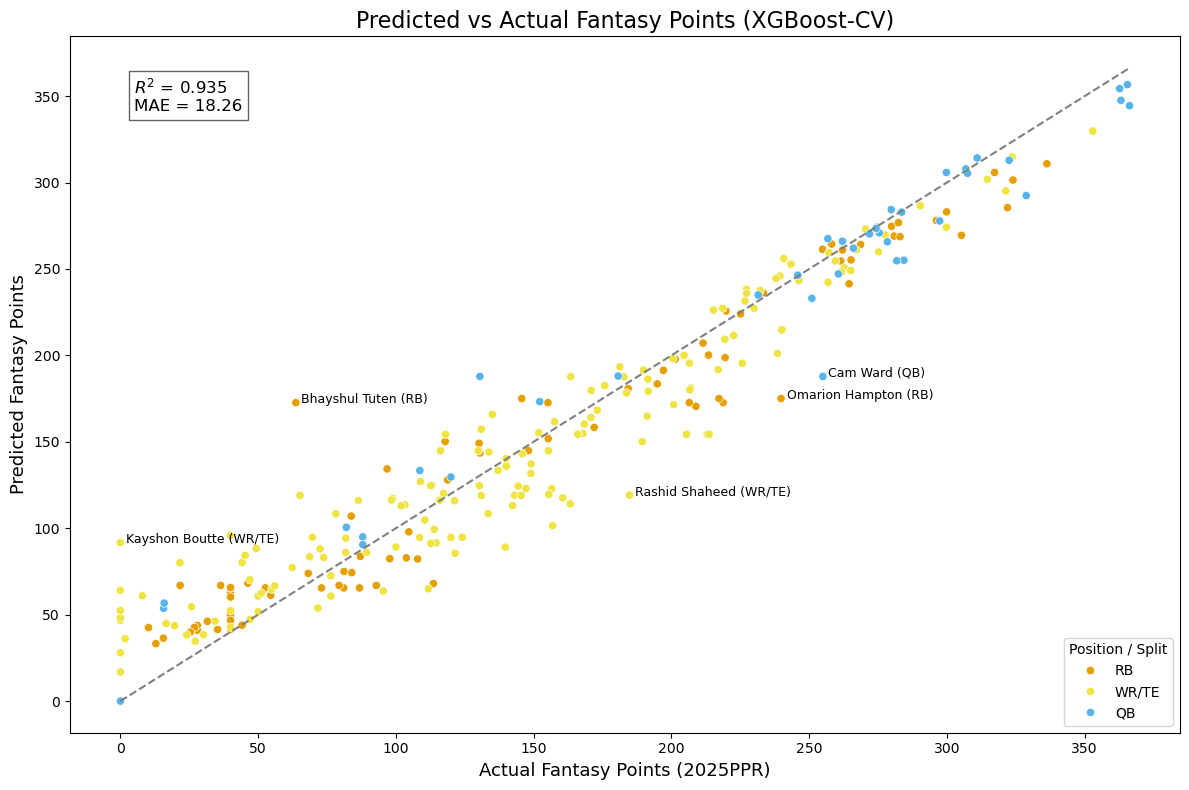

In [273]:
# Calculate metrics
r2 = r2_score(all_predictions['ESPN2025PPR'], all_predictions['Predicted Fantasy Points'])
mae = mean_absolute_error(all_predictions['ESPN2025PPR'], all_predictions['Predicted Fantasy Points'])

# Calculate residuals
all_predictions['Residual'] = np.abs(all_predictions['ESPN2025PPR'] - all_predictions['Predicted Fantasy Points'])

# Get top 5 outliers
top_outliers = all_predictions.nlargest(5, 'Residual')

# Colorblind-friendly palette (Color Universal Design)
color_palette = {
    'RB': '#E69F00',  # orange
    'WR/TE': '#F0E442',  # blue
    #'TE': '#009E73',  # green
    'QB': '#56B4E9'   # yellow
}

# Plotting
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=all_predictions,
    x='ESPN2025PPR',
    y='Predicted Fantasy Points',
    hue='FantPos',
    palette=color_palette
)

# Diagonal line for reference (perfect prediction)
min_val = min(all_predictions['ESPN2025PPR'].min(), all_predictions['Predicted Fantasy Points'].min())
max_val = max(all_predictions['ESPN2025PPR'].max(), all_predictions['Predicted Fantasy Points'].max())
plt.plot([min_val, max_val], [min_val, max_val], ls="--", color='gray')

# Annotate top residual outliers
for _, row in top_outliers.iterrows():
    plt.text(row['ESPN2025PPR'] + 2, row['Predicted Fantasy Points'],
             f"{row['Player']} ({row['FantPos']})", fontsize=9, color='black')

# Labels and title
plt.title('Predicted vs Actual Fantasy Points (XGBoost-CV)', fontsize=16)
plt.xlabel('Actual Fantasy Points (2025PPR)', fontsize=13)
plt.ylabel('Predicted Fantasy Points', fontsize=13)

# Display R² and MAE on the plot
plt.text(min_val + 5, max_val - 25,
         f"$R^2$ = {r2:.3f}\nMAE = {mae:.2f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.6))

# Legend and layout
plt.legend(title='Position / Split', loc='lower right')
plt.tight_layout()
plt.show()

In [275]:
all_predictions['ValuationDiff'] = all_predictions['Predicted Fantasy Points'] - all_predictions['ESPN2025PPR']

In [277]:
# Top 10 overvalued players (Predicted > Actual)
overvalued = all_predictions.sort_values(by='ValuationDiff', ascending=False).head(10)

print("Most Overvalued Fantasy Players:")
print(overvalued[['Player', 'FantPos', 'ESPN2025PPR', 'Predicted Fantasy Points', 'ValuationDiff']])

Most Overvalued Fantasy Players:
               Player FantPos  ESPN2025PPR  Predicted Fantasy Points  \
76     Bhayshul Tuten      RB         63.7                172.660004   
145    Kayshon Boutte   WR/TE          0.0                 91.660004   
108         Noah Fant   WR/TE          0.0                 64.110001   
80   Dontayvion Wicks   WR/TE         21.6                 80.059998   
38         Jaxon Dart      QB        130.5                187.839996   
73   Christian Watson   WR/TE         39.9                 95.860001   
148       Jaylin Noel   WR/TE         65.2                119.059998   
72       Ja'Lynn Polk   WR/TE          8.0                 60.930000   
116    Nelson Agholor   WR/TE          0.0                 52.360001   
86           DJ Chark   WR/TE          0.0                 48.139999   

     ValuationDiff  
76      108.960004  
145      91.660004  
108      64.110001  
80       58.459998  
38       57.339996  
73       55.960001  
148      53.859998  
72    

In [279]:
# Top 10 undervalued players (Actual > Predicted)
undervalued = all_predictions.sort_values(by='ValuationDiff').head(10)

print("Most Undervalued Fantasy Players:")
print(undervalued[['Player', 'FantPos', 'ESPN2025PPR', 'Predicted Fantasy Points', 'ValuationDiff']])

Most Undervalued Fantasy Players:
                Player FantPos  ESPN2025PPR  Predicted Fantasy Points  \
36            Cam Ward      QB        255.0                187.839996   
66      Rashid Shaheed   WR/TE        184.8                119.190002   
74     Omarion Hampton      RB        239.8                175.029999   
134  Tetairoa McMillan   WR/TE        213.7                154.360001   
131      Travis Hunter   WR/TE        213.0                154.360001   
65      Marquise Brown   WR/TE        156.9                101.500000   
135     Matthew Golden   WR/TE        205.5                154.360001   
154    Brenton Strange   WR/TE        139.7                 89.089996   
144     Cedric Tillman   WR/TE        163.3                114.089996   
93       Josh Reynolds   WR/TE        111.8                 64.980003   

     ValuationDiff  
36      -67.160004  
66      -65.609998  
74      -64.770001  
134     -59.339999  
131     -58.639999  
65      -55.400000  
135     -51.139